In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val
from src.hops import hops

In this notebook we want to compute the dynamics of the spin-boson model, using the linear HOPS equation

\begin{equation}
    \frac{\partial}{\partial t} \Psi^{(k)}_t = \left(-iH-k\omega+Lz_t^*\right) \Psi^{(k)}_t + k\alpha(0)L\Psi_t^{(k-1)} - L^\dagger\Psi_t^{(k+1)}
\end{equation}

The $\Psi^{(k)}$ are stored in $\left(2N_\text{trunc}\right)$-dimensional vector. One can then update them by using an appropriate integration scheme, eg. Euler or Runge-Kutta. We will use Runge-Kutta here:

\begin{equation}
\begin{split}
    y_{n+1} & = y_{n} + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right)\cdot h \\
    t_{n+1} & = t_n + h,
\end{split}
\end{equation}

where

\begin{equation}
\begin{split}
    k_1 & = f\left(t_n, y_n\right), \\
    k_2 & = f\left(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2}\right), \\
    k_3 & = f\left(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2}\right), \\
    k_4 & = f\left(t_n + h, y_n + hk_3\right).
\end{split}
\end{equation}

In our case $h = \Delta t$. The only term in the linear HOPS equation that is dependent on $t$ is the noise term with $z_t^*$. This means that we have to generate a stochastic process of length $2\cdot N_\text{steps}$ with time intervals of $\Delta t / 2$, because we will need to evaluate $f$ at half-time step intervals

Next we have to define the function $f$, that computes the R.H.S of the differential equation:

\begin{equation}
    f^{(k)}\left(t, \boldsymbol{\Psi}_t\right) = \frac{\partial}{\partial t} \boldsymbol{\Psi}_t
\end{equation}

We will work with a vector of states

\begin{equation}
    \boldsymbol{\Psi}_t \equiv
    \begin{pmatrix}
    \Psi_t^{(0)} \\
    \Psi_t^{(1)} \\
    \vdots \\
    \Psi_t^{(N_\text{trunc}-1)} \\
    \end{pmatrix}
\end{equation}

such that we can define the function $f$ in terms of propagators $M$ in matrix form.
We will split the function into a "linear" and a "noise" part:

\begin{equation}
f^{(k)}\left(t, \boldsymbol{\Psi}_t\right) = \left(M_\text{linear} + z_t^* \cdot M_\text{noise}\right) \boldsymbol{\Psi}_t 
\end{equation}

where we defined the linear propagator

\begin{equation}
    M_\text{linear} =
    \begin{pmatrix}
        -iH         & -L^\dagger           & 0                      & \cdots     &        &        & 0 \\
        \alpha(0)L  & -iH-\omega\mathbb{1} & -L^{\dagger}           & 0          & \cdots &        & 0 \\
        0           & 2\alpha(0)L          & -iH-2\omega\mathbb{1}  & -L^\dagger & 0      & \cdots & 0 \\
        \vdots      & \vdots               & \vdots                 & \vdots     & \vdots & \vdots & \vdots \\
    \end{pmatrix}
\end{equation}

and the noise propagator

\begin{equation}
    M_\text{noise} =
    \begin{pmatrix}
        L      & 0      & \cdots &        \\
        0      & L      & 0      & \cdots \\
        \vdots & 0      & L      & \ddots \\
               & \vdots & \ddots & \ddots \\
    \end{pmatrix}
\end{equation}

In [3]:
# parameters for the bath correlation functions
g = np.array([2])
w = np.array([0.5+2j])
# time
duration = 50
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
h = operators.generate_spin_boson_hamiltonian()
L = sigma_z

Without noise:


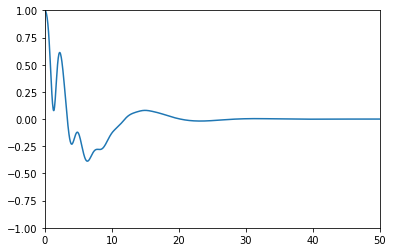

With noise:


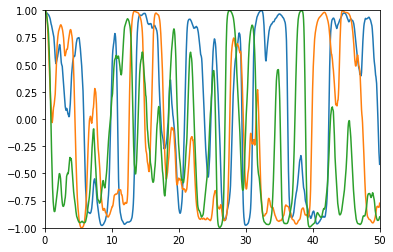

In [6]:
N_steps = 1000
N_trunc = 8
options = {
    'linear' : True,
    'use_noise' : False,
}

print("Without noise:")
options['use_noise'] = False
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
psis = my_hops.compute_realizations(1)
sigma_zs = compute_exp_val(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

print("With noise:")
options['use_noise'] = True
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
for i in range(3):
    psis = my_hops.compute_realizations(1)
    sigma_zs = compute_exp_val(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Varying the Step Count

In [5]:
N_steps_list = [500, 1000, 2000]
N_trunc = 8
N_samples = 1000
options = {
    'linear' : True,
    'use_noise' : False,
    'method' : 'RK4'
}

psi_list_step_count_no_noise = []

for N_steps in N_steps_list:
    print("N_steps =", N_steps)
    my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
    psis = my_hops.compute_realizations(N_samples, progressBar=tqdm)
    psi_list_step_count_no_noise.append(psis)

N_steps = 500


  0%|          | 0/1000 [00:00<?, ?it/s]

N_steps = 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

IndexError: list index out of range

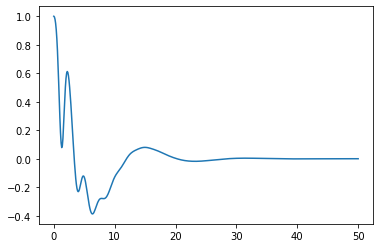

In [11]:
N_steps_list = [500, 1000, 2000]
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val(psi_list_step_count_no_noise[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label=str(N_steps)+" steps")
plt.legend()
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [14]:
N_steps_list = [500, 1000, 2000]
N_trunc = 8
N_samples = 1000

psi_list_step_count = []

for N_steps in N_steps_list:
    print("N_steps =", N_steps)
    my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
    psis = my_hops.compute_realizations(N_samples, progressBar=tqdm)
    psi_list_step_count.append(psis)

N_steps = 500


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
N_steps_list = [500, 1000, 2000]
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val(psi_list_step_count[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label=str(N_steps)+" steps")
plt.legend()
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Varying the truncation order

In [16]:
N_steps = 1000
N_trunc_list = [1, 2, 4, 8, 16]
N_samples = 1
options = {
    'linear' : True,
    'use_noise' : False,
    'method' : 'RK4'
}

psis_lis_truncation_order_without_noise = []

for N_trunc in N_trunc_list:
    print("N_trunc =", N_trunc)
    my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
    psis = my_hops.compute_realizations(N_samples)
    psis_lis_truncation_order_without_noise.append(psis)

N_trunc = 1
N_trunc = 2
N_trunc = 4
N_trunc = 8
N_trunc = 16


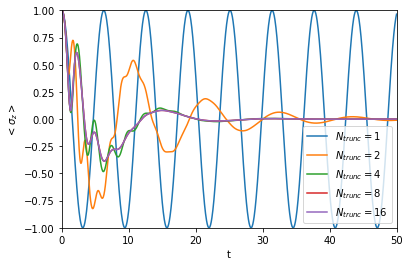

In [17]:
N_steps = 1000
N_trunc_list = [1, 2, 4, 8, 16]
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val(psis_lis_truncation_order_without_noise[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="$N_{trunc} = "+str(N_trunc)+"$")
plt.legend()
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [18]:
N_steps = 1000
N_trunc_list = [1, 2, 4, 8, 16]
N_samples = 1000
options = {
    'linear' : True,
    'use_noise' : True,
    'method' : 'RK4'
}

psis_lis_truncation_order_with_noise = []

for N_trunc in N_trunc_list:
    print("N_trunc =", N_trunc)
    hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
    psis = my_hops.compute_realizations(N_samples, progressBar=tqdm)
    psis_lis_truncation_order_with_noise.append(psis)

N_trunc = 1


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
N_trunc_list = [1, 2, 4, 8, 16]
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val(psis_lis_truncation_order_with_noise[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="$N_{trunc} = "+str(N_trunc)+"$")
plt.legend(loc="right")
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Varying the number of samples

In [15]:
N_steps = 1000
N_trunc = 16
options = {
    'linear' : True,
    'use_noise' : True
}

In [16]:
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)

In [21]:
my_hops.compute_realizations(N_samples=100, progressBar=tqdm, data_path="data/linear_100/psi")

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
my_hops.compute_realizations(N_samples=1000, progressBar=tqdm, data_path="data/linear_1000/psi")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
my_hops.compute_realizations(N_samples=10000, progressBar=tqdm, data_path="data/linear_10000/psi")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
psis_100 = np.array([np.load("data/linear_100/psi"+str(n)+".npy") for n in range(100)])
psis_1000 = np.array([np.load("data/linear_1000/psi"+str(n)+".npy") for n in range(1000)])
psis_10000 = np.array([np.load("data/linear_10000/psi"+str(n)+".npy") for n in range(10000)])
sigma_zs_100 = compute_exp_val(psis_100, sigma_z)
sigma_zs_1000 = compute_exp_val(psis_1000, sigma_z)
sigma_zs_10000 = compute_exp_val(psis_10000, sigma_z)

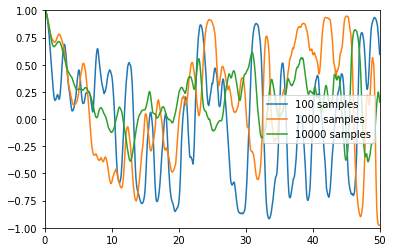

In [38]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_10000, label="10000 samples")
plt.legend(loc="right")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# magnitudes of the sampled states

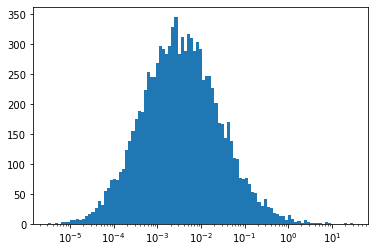

In [39]:
magnitudes = []
for i in range(10000):
    # take the final state of each sample
    magnitudes.append(np.linalg.norm(psis_10000[i, -1, :]))
    
lowest = np.min(magnitudes)
largest = np.max(magnitudes)
bins = np.logspace(np.log10(lowest), np.log10(largest), 100)

plt.hist(magnitudes, bins=bins)
plt.xscale("log")
plt.show()